In [2]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

w = 160
h = 90

# 输入形状: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, w, h))  

y = MultiBoxPrior(x, sizes=[0.0417], ratios=[0.5625])

# 取位于 (20,20) 像素点的第一个预设框
# 格式为 (x_min, y_min, x_max, y_max)
boxes = y.reshape((w, h, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[ 0.19071111  0.10727499  0.26484445  0.148975  ]
<NDArray 4 @cpu(0)>


# 分类预测

总共一个anchor,9类


class_predictor和box_predictor返回的是类的概率

In [3]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(1, 9)
cls_pred.initialize()
x = nd.zeros((2, 3, 5, 5))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 10, 5, 5)


# 框偏移预测

In [4]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(1)
box_pred.initialize()
x = nd.zeros((2, 3, 5, 5))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 4, 5, 5)


# 下采样特征层 Down-sample features

每次我们下采样特征层到一半的长宽，用Pooling(池化)操作就可以轻松的做到，当然也可以用stride(步长)为2的卷积直接得到。在下采样之前，我们会希望增加几层卷积层作为缓冲，防止特征值对应多尺度带来的混乱，同时又能增加网络的深度，得到更好的抽象。

下面的num_filters是输出层的个数

In [5]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


# 主干网络 Body network

主干网络用来从原始图像输入提取特征。 一般来说我们会用预先训练好的用于分类的高性能网络（VGG, ResNet等）来提取特征。

在这里我们就简单地堆叠几层卷积和下采样层作为主干网络的演示。

In [6]:
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


# 设计一个简单的单尺度检测网络 Create a toy sing scale detection model

我们这里介绍一个示意用的简单单尺度网络

In [7]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    #downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    for scale in range(1):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), class_preds, box_preds

print(toy_ssd_model(1, 9))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (2): HybridSequential(
    (0): C

# 网络前向推导 Forward



In [8]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [9]:
def toy_ssd_forward(x, body,  class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(1):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        

    return default_anchors, predicted_classes, predicted_boxes

# 整个网络

In [10]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # 1个预测层
        self.anchor_sizes = [[0.0417]]
        # 每层的预设框都用 1，2，0.5作为长宽比候选
        self.anchor_ratios = [[0.5625]]
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.class_preds, self.box_preds = toy_ssd_model(1, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body,self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # 把从每个预测层输入的结果摊平并连接，以确保一一对应
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # 改变下形状，为了更方便地计算softmax
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

# 加载数据 Load dataset

加载数据可以用mxnet.image.ImageDetIter，同时还提供了大量数据增强的选项，比如翻转，随机截取等等。

In [46]:
ls

UTS_01/                  labelImg/            pack.zip  xmls/
ball_detection.md.ipynb  labelImg-master/     val.idx   新建文本文档.txt
class_list/              labelImg-master.zip  val.lst
images/                  mxnet/               val.rec


In [11]:
import mxnet.image as image
data_width1  = 1280
data_height1 = 720
batch_size = 6
def get_iterators(data_width,data_height, batch_size):
    class_names = ['chi','cheng','hong','lv','qing','lan','lan','zi','bai']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_height,data_width),
        #path_imgrec='./data/pikachu_train.rec',
        #path_imgidx='./data/pikachu_train.idx',
        path_imglist='./images/train.lst',
        path_root='./images/',
        mean=True)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_width, data_height),
        path_imglist='./images/train.lst',
        path_root='./images/',
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_width1, data_height1, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(6, 3, 720, 1280)] label shapes: [(6, 8, 5)]


[ 1.          0.68906248  0.50138891  0.72031248  0.55694443]
[ 2.          0.62578124  0.51944447  0.65703124  0.57499999]
[ 3.          0.65859377  0.51111114  0.68984377  0.56666666]
[ 4.          0.59140623  0.52083331  0.62265623  0.5763889 ]
[ 5.          0.48124999  0.52361113  0.51249999  0.57916665]
[ 7.          0.5546875   0.52638888  0.5859375   0.58194447]
[ 8.          0.51953125  0.52916664  0.55078125  0.58472222]
[ 0.          0.453125    0.48055556  0.484375    0.53611112]


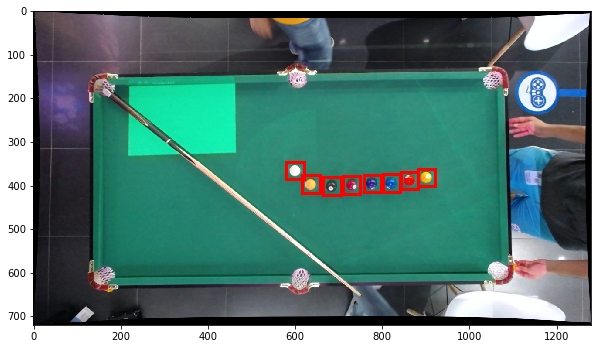

In [39]:
import numpy as np
import matplotlib.pyplot as plt

img = batch.data[0][0].asnumpy()  # 取第一批数据中的第一张，转成numpy
img = img.transpose((1, 2, 0))  # 交换下通道的顺序
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # 图片应该用0-255的范围
# 在图上画出真实标签的方框
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin = label[1] * data_width1
    ymin = label[2] * data_height1
    xmax = label[3] * data_width1
    ymax = label[4] * data_height1
    #xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()

# 训练 Train

## 损失函数 Losses

预测的类别和偏移量都是可以通过真实标签和网络的当前预测值得到，在这里我们用**MultiBoxTarget**层来计算，其中包含了预测框和真实标签的匹配，正类和负类的选择


In [12]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # 预设框偏移量 (x, y, width, height)
    box_mask = z[1]  # box_mask用来把负类的偏移量置零，因为背景不需要位置！
    cls_target = z[2]  # 每个预设框应该对应的分类
    return box_target, box_mask, cls_target


对于物体分类的概率，平时我们往往用交叉墒。在目标检测中，我们有大量非平衡的负类（背景），那么 **Focal Loss** 会是一个很好的选择（详情见论文 Focal Loss for Dense Object Detection）

In [13]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


接下来是一个流行的 **SmoothL1 损失函数**，用来惩罚不准确的预设框偏移量。

In [14]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


## 衡量性能指标 Evaluate metrics



用准确率衡量分类的性能，用平均绝对误差衡量偏移量的预测能力。

In [15]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE() 

## 选择训练用的设备 Set context for training


In [16]:
ctx = mx.gpu()  # 用GPU加速训练过程
try:
    _ = nd.zeros(1, ctx=ctx)
    # 为了更有效率，cuda实现需要少量的填充，不影响结果
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    # 没有gpu也没关系，交给cpu慢慢跑
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

No GPU enabled, fall back to CPU, sit back and be patient...


## 初始化网络参数 Initialize parameters



In [17]:
net = ToySSD(9)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)


## 用gluon.Trainer简化训练过程 Set up trainer

gluon.Trainer能简化优化网络参数的过程，免去对各个参数单独更新的痛苦。

In [18]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

## 开始训练 Start training

可以设置
```
from_scratch = True
```
这样网络就会从初始的随机参数开始训练。



In [19]:
epochs = 10  # 设大一点的值来得到更好的结果
log_interval = 5
from_scratch = True  # 设为True就可以从头开始训练
if from_scratch:
    start_epoch = 0

import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # 重置iterator和时间戳
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # 迭代每一个批次
    for i, batch in enumerate(train_data):
        btic = time.time()
        # 用autograd.record记录需要计算的梯度
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # 损失函数计算
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # 1比1叠加两个损失函数，也可以加权重
            loss = loss1 + loss2
            # 反向推导
            loss.backward()
        # 用trainer更新网络参数
        trainer.step(batch_size)
        # 更新下衡量的指标
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # 打印整个epoch的的指标
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# 还可以把网络的参数存下来以便下次再用
net.save_params('ssd_%d.params' % epochs)

[Epoch 0 Batch 4] speed: 0.592381 samples/s, training: accuracy=0.810944, mae=0.003869
[Epoch 0] training: accuracy=0.839525, mae=0.003582
[Epoch 0] time cost: 92.149226
[Epoch 1 Batch 4] speed: 0.596280 samples/s, training: accuracy=0.998086, mae=0.003012
[Epoch 1] training: accuracy=0.956489, mae=0.002835
[Epoch 1] time cost: 99.143769
[Epoch 2 Batch 4] speed: 0.605074 samples/s, training: accuracy=0.998086, mae=0.002574
[Epoch 2] training: accuracy=0.956489, mae=0.002441
[Epoch 2] time cost: 99.520466
[Epoch 3 Batch 4] speed: 0.589758 samples/s, training: accuracy=0.998086, mae=0.002311
[Epoch 3] training: accuracy=0.956489, mae=0.002203
[Epoch 3] time cost: 98.984381
[Epoch 4 Batch 4] speed: 0.599064 samples/s, training: accuracy=0.998086, mae=0.002146
[Epoch 4] training: accuracy=0.956489, mae=0.002050
[Epoch 4] time cost: 99.931897
[Epoch 5 Batch 4] speed: 0.595543 samples/s, training: accuracy=0.998086, mae=0.002031
[Epoch 5] training: accuracy=0.956489, mae=0.001943
[Epoch 5] t

In [20]:
ls

UTS_01/                  labelImg/            pack.zip       val.rec
ball_detection.md.ipynb  labelImg-master/     ssd_10.params  xmls/
class_list/              labelImg-master.zip  val.idx        新建文本文档.txt
images/                  mxnet/               val.lst


# 测试

In [34]:
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # 调整图片大小成网络的输入
    image = cv2.resize(image, (data_width1, data_height1))
    # 转换 BGR 到 RGB
    image = image[:, :, (2, 1, 0)]
    # 减mean之前先转成float
    image = image.astype(np.float32)
    # 减 mean
    image -= np.array([123, 117, 104])
    # 调成为 [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # 转成 ndarray
    image = nd.array(image)
    return image

image = cv2.imread('./images/0008.jpg')
x = preprocess(image)
print('x', x.shape)

x (1, 3, 720, 1280)


In [35]:
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)


anchors 
[[[-0.00860313 -0.01529445  0.01485313  0.02640556]
  [-0.00235313 -0.01529445  0.02110313  0.02640556]
  [ 0.00389687 -0.01529445  0.02735313  0.02640556]
  ..., 
  [ 0.97264689  0.97359449  0.99610311  1.01529443]
  [ 0.97889692  0.97359449  1.00235319  1.01529443]
  [ 0.98514688  0.97359449  1.0086031   1.01529443]]]
<NDArray 1x14400x4 @cpu(0)>
class predictions 
[[[ 3.64401078 -0.01128018  0.66695333 ..., -2.04918528 -0.67051101
    0.26071841]
  [ 5.21928024 -0.18524161  0.2311831  ..., -1.17497981 -0.68487412
    0.95477396]
  [ 4.27631664  0.86416197  0.99847353 ..., -0.43572482 -0.40793812
    0.75919765]
  ..., 
  [ 4.26394844 -1.11391485  1.57417536 ..., -0.3702088   1.54133093
    1.07801509]
  [ 4.18885231 -0.58330578  1.94128811 ..., -0.25819886  1.68688154
    0.95105088]
  [ 2.68165779 -0.86736631  0.95463938 ..., -0.8459937  -0.14002341
    0.03439867]]]
<NDArray 1x14400x10 @cpu(0)>
box delta predictions 
[[-0.34889126  0.16956259 -0.71234179 ..., -1.3609519   

In [36]:
from mxnet.contrib.ndarray import MultiBoxDetection
# 跑一下softmax， 转成0-1的概率
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# 把偏移量加到预设框上，去掉得分很低的，跑一遍nms，得到最终的结果
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 1.          0.31402686  0.40347874  0.33613366  0.44224566  0.38737017]
  [ 0.          0.27475986  0.10483007  0.13418625  0.13921781  0.193083  ]
  [ 0.          0.26157168  0.45333815  0.54606616  0.48180652  0.60016406]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x14400x6 @cpu(0)>
